*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.2.0

torch 1.0.0


# Model Zoo -- Using PyTorch Dataset Loading Utilities for Custom Datasets (Images from Quickdraw)

This notebook provides an example for how to load an image dataset, stored as individual PNG files, using PyTorch's data loading utilities. For a more in-depth discussion, please see the official

- [Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [torch.utils.data](http://pytorch.org/docs/master/data.html) API documentation

In this example, we are using the Quickdraw dataset consisting of handdrawn objects, which is available at https://quickdraw.withgoogle.com. 

To execute the following examples, you need to download the ".npy" (bitmap files in NumPy). You don't need to download all of the 345 categories but only a subset you are interested in. The groups/subsets can be individually downloaded from https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap

Unfortunately, the Google cloud storage currently does not support selecting and downloading multiple groups at once. Thus, in order to download all groups most coneniently, we need to use their `gsutil` (https://cloud.google.com/storage/docs/gsutil_install) tool. If you want to install that, you can then use 

    mkdir quickdraw-npy
    gsutil -m cp gs://quickdraw_dataset/full/numpy_bitmap/*.npy quickdraw-npy

Note that if you download the whole dataset, this will take up 37 Gb of storage space.


## Imports

In [2]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

## Dataset

After downloading the dataset to a local directory, `quickdraw-npy`, the next step is to select certain groups we are interested in analyzing. Let's say we are interested in the following groups defined in the `label_dict` in the next code cell:

In [3]:
label_dict = {
         "lollipop": 0,
         "binoculars": 1,
         "mouse": 2,
         "basket": 3,
         "penguin": 4,
         "washing machine": 5,
         "canoe": 6,
         "eyeglasses": 7,
         "beach": 8,
         "screwdriver": 9,
}

The dictionary values shall represent class labels that we could use for a classification task, for example.

### Conversion to PNG files

Next we are going to convert the groups we are interested in (specified in the dictionary above) to individual PNG files using a helper function (note that this might take a while):

In [4]:
from helper import quickdraw_npy_to_imagefile

    
quickdraw_npy_to_imagefile(inpath='quickdraw-npy',
                           outpath='quickdraw-png_set1',
                           subset=label_dict.keys())

### Preprocessing into train/valid/test subsets and creating a label files

For convenience, let's create a CSV file mapping file names to class labels. First, let's collect the files and labels.

In [5]:
paths, labels = [], []

main_dir = 'quickdraw-png_set1/'

for d in os.listdir(main_dir):
    subdir = os.path.join(main_dir, d)
    if not os.path.isdir(subdir):
        continue
    for f in os.listdir(subdir):
        path = os.path.join(d, f)
        paths.append(path)
        labels.append(label_dict[d])
        
print('Num paths:', len(paths))
print('Num labels:', len(labels))

Num paths: 1515745
Num labels: 1515745


Next, we shuffle the dataset and assign 70% of the dataset for training, 10% for validation, and 20% for testing.

In [6]:
from mlxtend.preprocessing import shuffle_arrays_unison


paths2, labels2 = shuffle_arrays_unison(arrays=[np.array(paths), np.array(labels)], random_seed=3)


cut1 = int(len(paths)*0.7)
cut2 = int(len(paths)*0.8)

paths_train, labels_train = paths2[:cut1], labels2[:cut1]
paths_valid, labels_valid = paths2[cut1:cut2], labels2[cut1:cut2]
paths_test, labels_test = paths2[cut2:], labels2[cut2:]

Finally, let us create a CSV file that maps the file paths to the class labels (here only shown for the training set for simplicity):

In [7]:
df = pd.DataFrame(
    {'Path': paths_train,
     'Label': labels_train,
    })

df = df.set_index('Path')
df.to_csv('quickdraw_png_set1_train.csv')

df.head()

,Label
Path,
penguin/penguin_182463.png,4
mouse/mouse_139942.png,2
screwdriver/screwdriver_066105.png,9
beach/beach_026711.png,8
eyeglasses/eyeglasses_035833.png,7


Finally, let's open one of the images to make sure they look ok:

(28, 28)


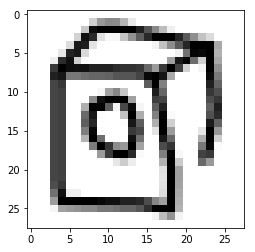

In [8]:
main_dir = 'quickdraw-png_set1/'

img = Image.open(os.path.join(main_dir, df.index[99]))
img = np.asarray(img, dtype=np.uint8)
print(img.shape)
plt.imshow(np.array(img), cmap='binary');

## Implementing a Custom Dataset Class

Now, we implement a custom `Dataset` for reading the images. The `__getitem__` method will

1. read a single image from disk based on an `index` (more on batching later)
2. perform a custom image transformation (if a `transform` argument is provided in the `__init__` construtor)
3. return a single image and it's corresponding label

In [9]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=",", index_col=0)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df.index.values
        self.y = df['Label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

Now that we have created our custom Dataset class, let us add some custom transformations via the `transforms` utilities from `torchvision`, we

1. normalize the images (here: dividing by 255)
2. converting the image arrays into PyTorch tensors

Then, we initialize a Dataset instance for the training images using the 'quickdraw_png_set1_train.csv' label file (we omit the test set, but the same concepts apply).

Finally, we initialize a `DataLoader` that allows us to read from the dataset.

In [10]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = QuickdrawDataset(txt_path='quickdraw_png_set1_train.csv',
                                 img_dir='quickdraw-png_set1/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=4) 

That's it, now we can iterate over an epoch using the train_loader as an iterator and use the features and labels from the training dataset for model training:

## Iterating Through the Custom Dataset

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


Just to make sure that the batches are being loaded correctly, let's print out the dimensions of the last batch:

In [12]:
x.shape

torch.Size([128, 1, 28, 28])

As we can see, each batch consists of 128 images, just as specified. However, one thing to keep in mind though is that
PyTorch uses a different image layout (which is more efficient when working with CUDA); here, the image axes are "num_images x channels x height x width" (NCHW) instead of "num_images height x width x channels" (NHWC):

To visually check that the images that coming of the data loader are intact, let's swap the axes to NHWC and convert an image from a Torch Tensor to a NumPy array so that we can visualize the image via `imshow`:

In [13]:
one_image = x[0].permute(1, 2, 0)
one_image.shape

torch.Size([28, 28, 1])

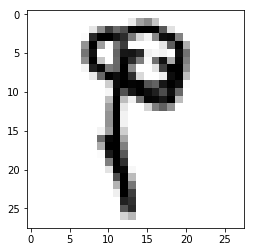

In [16]:
# note that imshow also works fine with scaled
# images in [0, 1] range.
plt.imshow(one_image.to(torch.device('cpu')).squeeze(), cmap='binary');

In [17]:
%watermark -iv

numpy       1.15.4
pandas      0.23.4
torchvision 0.2.1
torch       1.0.0
PIL.Image   5.3.0
matplotlib  3.0.2

